In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sb
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

/Users/ankit/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/ankit/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def parse_function(example_proto):
    features = {
        'image':tf.FixedLenFeature((),tf.string),
        'label':tf.FixedLenFeature((),tf.int64)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    features = {'image':tf.decode_raw(parsed_features["image"],tf.uint8)}
    labels = tf.cast(parsed_features["label"], tf.int32)
    return features,labels

In [3]:
def get_train_input():
    dataset = tf.data.TFRecordDataset('train.tfrecord')
    return dataset.map(parse_function).batch(50).prefetch(64)#.take(10000)

def get_test_input():
    dataset = tf.data.TFRecordDataset('test.tfrecord').map(parse_function).batch(50).prefetch(64)#.take(10000)
    return dataset

def get_test_input_single():
    dataset = tf.data.TFRecordDataset('test.tfrecord').map(parse_function).batch(1).prefetch(64)#.take(10000)
    return dataset


In [4]:
feature_columns = [
    tf.feature_column.numeric_column(key='image',shape=(28,28))
]

In [5]:
estimator = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[512,256,128],
    n_classes=62,
    model_dir='estimator_logs',
    batch_norm=True
)
def prec(features, labels, predictions):
    print(labels)
    print(predictions)
    return {'precision': tf.metrics.precision(labels, predictions['class_ids'])}
def rec(features, labels, predictions):
    return {'recall': tf.metrics.recall(labels, predictions['class_ids'])}
def f1(features, labels, predictions):
    return {'f1_score': tf.contrib.metrics.f1_score(labels, predictions['class_ids'])}

estimator = tf.contrib.estimator.add_metrics(estimator,prec)
estimator = tf.contrib.estimator.add_metrics(estimator,rec)
#estimator = tf.contrib.estimator.add_metrics(estimator,f1)

In [6]:
estimator.train(input_fn=get_train_input,steps=15000)

In [7]:
estimator.evaluate(input_fn=get_test_input)

Tensor("IteratorGetNext:1", shape=(?,), dtype=int32)
{'logits': <tf.Tensor 'dnn/logits/BiasAdd:0' shape=(?, 62) dtype=float32>, 'probabilities': <tf.Tensor 'dnn/head/predictions/probabilities:0' shape=(?, 62) dtype=float32>, 'class_ids': <tf.Tensor 'dnn/head/predictions/ExpandDims:0' shape=(?, 1) dtype=int64>, 'classes': <tf.Tensor 'dnn/head/predictions/str_classes:0' shape=(?, 1) dtype=string>}


{'accuracy': 0.84281915,
 'average_loss': 0.5811712,
 'global_step': 18048,
 'loss': 29.05856,
 'precision': 0.9906851,
 'recall': 0.9941848}

In [8]:
def get_toy_dataset():
    dataset = tf.data.TFRecordDataset('test.tfrecord')
    return dataset.map(parse_function).batch(1).take(50)#.take(10000)

toy_dataset = get_toy_dataset()
def get_examples():
    with tf.Session() as sess:
        for _ in range(20):
            try:
                it = toy_dataset.shuffle(10).make_one_shot_iterator()
                features,label = it.get_next()
                features['image'] = features['image'].eval()
                label = label.eval()
                yield features,label
            except:
                break


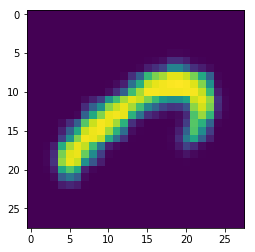

actual:[3] predicted:[12]


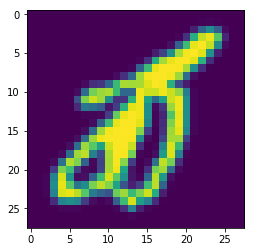

actual:[3] predicted:[11]


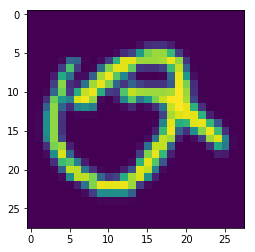

actual:[3] predicted:[26]


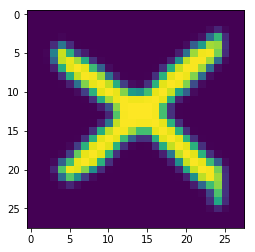

actual:[9] predicted:[33]


In [9]:
for example in get_examples():
    for i in estimator.predict(input_fn=lambda:example):
        actual = example[1]
        if actual>9:
            break
        image = example[0]['image']
        pred = i['class_ids']
        image.resize((28,28))
        plt.imshow(image)
        plt.show()
        print('actual:{} predicted:{}'.format(actual,pred))
        break


In [10]:
def get_actuals(dataset):
    i = dataset.make_one_shot_iterator()
    while True:
        try:
            a,b = i.get_next()
            yield b.eval()[0]
        except:
            return

In [11]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(12,12))
    plt.title("Confusion Matrix")
    sb.heatmap(matrix,xticklabels=1,square=True,cbar=False)
    plt.show()

with tf.Session() as sess:
    actuals = get_actuals(get_test_input_single())
    preds = [i['class_ids'][0] for i in estimator.predict(input_fn=get_test_input_single)]
    actuals = list(actuals)
    #matrix = tf.confusion_matrix(preds,actuals).eval()
    #plot_confusion_matrix(matrix)